# Functional Genomics Final Project

## Comparative gene expression analysis on juvenile idiopathic arthritis and inflammatory bowel disease data

### Emma Yu

In [13]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy
import warnings
warnings.filterwarnings('ignore')
pd.reset_option('^display.', silent=True)
pd.set_option('display.precision', 3)

# Introduction/Objective

In this project, I conducted two comparative gene expression analyses, over-representation analysis and Gene Set Enrichment Analysis, on juvenile idiopathic arthritis and inflammatory bowel disease gene fold change data to determine whether four immune system signaling pathways are over-expressed in these diseases.

**Objectives**
* Test whether adaptive and innate immune system signaling pathways are overexpressed in juvenile idiopathic arthritis (JIA) and inflammatory bowel diseases (IBD)
    * Over-representation analysis (ORA)
    * Gene Set Enrichment Analysis (GSEA)
* Biologically explain the statistical analysis results 
* Compare results to the findings from the data source publication
* Visualize genetic expression data and analysis results

# Data

## Fold change data between diseases and normal subjects

This is a dataset taken from Gene Expression Atlas database. The data contains fold changes and the corresponding p-values between "normal" subjects and those with either Crohn disease, ulcerative colitis, oligoarticulator juvenile idiopathic arthritis (oJIA), polyarticular juvenile idiopathic arthritis (pJIA), or systemic-onset juvenile idiopathic arthritis (sJIA). Crohn disease and ulcerative colitis can be grouped as inflammatory bowel diseases (IBD) and the other three conditions are subtypes of juvenile idiopathic arthritis (JIA).

The paper (Mo et al.) that provided the dataset found that sJIA is most similar to IBD when compared to the other two subtypes of JIA. They also mentioned that like IBD, sJIA is involved in the innate immune system while pJIA and oJIA involve more of the adaptive immune system. In this project, I plan on confirming these claims by running over-representation analysis (ORA) and Gene Set Enrichment Analysis (GSEA) using signaling pathways involved in the innate and adaptive immune systems.

The dataset contains 20,473 observations and 12 variables, two of which are identifier variables. All of the data columns had missing values. Crohn diseases variables had a missing value percentage of 18%, ulcerative colitis variables 8.5%, oJIA variables 35%, pJIA variables 32%, and sJIA variables 22%.

In [3]:
de_df = pd.read_csv('data/E-GEOD-112057-query-results.tsv', sep='\t', header=3)
de_df

,Gene ID,Gene Name,'Crohn disease' vs 'normal' .foldChange,'Crohn disease' vs 'normal'.pValue,'oligoarticular juvenile idiopathic arthritis' vs 'normal' .foldChange,'oligoarticular juvenile idiopathic arthritis' vs 'normal'.pValue,'polyarticular juvenile idiopathic arthritis' vs 'normal' .foldChange,'polyarticular juvenile idiopathic arthritis' vs 'normal'.pValue,'systemic-onset juvenile idiopathic arthritis' vs 'normal' .foldChange,'systemic-onset juvenile idiopathic arthritis' vs 'normal'.pValue,'ulcerative colitis (disease)' vs 'normal' .foldChange,'ulcerative colitis (disease)' vs 'normal'.pValue
0,ENSG00000000003,TSPAN6,NaN,NaN,0.2,0.535,0.1,0.845,0.1,0.806,-0.4,0.244
1,ENSG00000000419,DPM1,0.3,0.018,0.1,0.706,0.2,0.162,0.2,0.144,0.4,0.003
2,ENSG00000000457,SCYL3,NaN,NaN,NaN,NaN,0.1,0.551,0.1,0.443,NaN,NaN
3,ENSG00000000460,C1orf112,-0.1,0.594,0.1,0.599,0.1,0.541,0.1,0.663,NaN,NaN
4,ENSG00000000938,FGR,0.2,0.245,-0.1,0.541,NaN,NaN,0.4,0.135,0.5,0.049
...,...,...,...,...,...,...,...,...,...,...,...,...
20468,ENSG00000285967,NIPBL-DT,-0.1,0.777,0.1,0.659,0.1,0.436,0.1,0.601,-0.1,0.659
20469,ENSG00000285976,ENSG00000285976,0.5,0.101,0.4,0.153,0.2,0.562,0.6,0.178,0.7,0.079
20470,ENSG00000285979,ENSG00000285979,NaN,NaN,0.2,0.594,0.4,0.065,0.3,0.358,-0.1,0.846
20471,ENSG00000285984,ENSG00000285984,1.0,0.007,NaN,NaN,NaN,NaN,1.2,0.014,1.4,0.008


URL: https://www.ebi.ac.uk/gxa/experiments/E-GEOD-112057/Results <br>
Mo A, Marigorta UM, Arafat D, Chan LHK, Ponder L, Jang SR, Prince J, Kugathasan S, Prahalad S, Gibson G. Disease-specific regulation of gene expression in a comparative analysis of juvenile idiopathic arthritis and inflammatory bowel disease. Genome Med. 2018 Jun;10(1) 48. https://doi.org/10.1186/s13073-018-0558-x.  

## Data Wrangling: Fold change data between juvenile idiopathic arthritis (JIA) and inflammatory bowel diseases

Since the publication associated with the dataset compared IBD to the three subtypes of JIA, I also created two datasets using the raw counts data from the database. The first contains data on fold change between the three subtypes of JIA and Crohn disease (`de_df_cd`), while the second set contains data on fold change between the three subtypes of JIA and ulcerative colitis (`de_df_uc`).

In order to account for the difference in sample size between the diseases, I first normalized the raw counts data by trimmed mean of m-values (TMM) and calculated the fold changes and corresponding p-values. I also corrected the p-values (now denoted as q-values) using the Benjamini-Hochberg method to control the false discovery rate.

In [4]:
# calculates TMM value between ref_col and test_col
def get_tmm(counts, ref_col, test_col, trim_m=0.30, trim_a=0.05):
    if ref_col == test_col:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col]]
    else:
        counts_slim = counts[(counts[ref_col].values > 0) & (counts[test_col].values > 0)][[ref_col, test_col]]

    n_k = counts_slim[test_col].sum()
    n_r = counts_slim[ref_col].sum()

    m_k = np.log2(counts_slim[test_col].values/n_k)-np.log2(counts_slim[ref_col].values/n_r)
    a_k = 0.5*np.log2((counts_slim[test_col].values/n_k)*(counts_slim[ref_col].values/n_r))
    w_k = (n_k - counts_slim[test_col].values)/(n_k*counts_slim[test_col].values) + (n_r - counts_slim[ref_col].values)/(n_r*counts_slim[ref_col].values)

    trim_array_m = (m_k <= np.percentile(m_k, 100*(1-(trim_m/2)))) & ((m_k >= np.percentile(m_k, 100*((trim_m/2)))))
    trim_array_a = (a_k <= np.percentile(a_k, 100*(1-(trim_a/2)))) & ((a_k >= np.percentile(a_k, 100*((trim_a/2)))))

    m_k = m_k[trim_array_m & trim_array_a]
    a_k = a_k[trim_array_m & trim_array_a]
    w_k = w_k[trim_array_m & trim_array_a]
    tmm_k = 2**(np.sum(w_k*m_k)/np.sum(w_k))
    return tmm_k

# normalizes count matrix by TMM
def norm_tmm(counts, columns_to_norm, ref_col=None):
    if ref_col == None:
        ref_col = columns_to_norm[0]
    counts[counts.columns[~counts.columns.isin(cols_to_norm)]]
        
    tmm_array = []
    for col in columns_to_norm:
        tmm_array.append(get_tmm(counts = counts, ref_col=ref_col, test_col=col))
    tmm_array = np.array(tmm_array)

    norm_counts = counts[columns_to_norm]/(np.sqrt(tmm_array)*counts[columns_to_norm].sum(axis=0))
    norm_counts[counts.columns[~counts.columns.isin(columns_to_norm)]] = counts[counts.columns[~counts.columns.isin(columns_to_norm)]]
    return norm_counts

In [5]:
# array containing disease name and how it's spelled in the dataset
diseases = [["'Crohn disease'", "Crohn Disease", "Crohn Disease"], 
            ["'ulcerative colitis (disease)'", "Ulcerative Colitis", "Ulcerative Colitis"],
            ["'oligoarticular juvenile idiopathic arthritis'", "Oligoarticular Juvenile Idiopathic Arthritis",
             "oJIA"],
            ["'polyarticular juvenile idiopathic arthritis'", "Polyarticular Juvenile Idiopathic Arthritis",
             "pJIA"],
            ["'systemic-onset juvenile idiopathic arthritis'", "Systemic-onset Juvenile Idiopathic Arthritis",
             "sJIA"]]

# import raw count and experiment design datasets
counts = pd.read_csv('data/E-GEOD-112057-raw-counts.tsv', sep='\t').drop("Gene ID", axis = 1)
counts = counts.dropna(subset=['Gene Name'])
design = pd.read_csv('data/E-GEOD-112057-experiment-design.tsv', sep='\t')
design = design[design['Analysed'] == 'Yes'].reset_index(drop=True)

# create disease labels
design['labels'] = ['']*len(design)
design['labels'].loc[(design['Factor Value[disease]'].values == "Crohn disease")] = 'CD'
design['labels'].loc[(design['Factor Value[disease]'].values == "ulcerative colitis (disease)")] = 'UC'
design['labels'].loc[(design['Factor Value[disease]'].values == "polyarticular juvenile idiopathic arthritis")] = 'PJIA'
design['labels'].loc[(design['Factor Value[disease]'].values == "oligoarticular juvenile idiopathic arthritis")] = 'OJIA'
design['labels'].loc[(design['Factor Value[disease]'].values == "systemic-onset juvenile idiopathic arthritis")] = 'SJIA'
design['labels'].loc[(design['Factor Value[disease]'].values == "normal")] = 'NORM'

design = design.sort_values('labels')
cols_to_norm = design['Run'].values
labels = design['labels'].values

# normalize counts dataframe
counts_norm = counts.copy()
counts_norm = norm_tmm(counts_norm, columns_to_norm=cols_to_norm, ref_col=cols_to_norm[0])

# list of counts_norm columns
sample_names = counts_norm.columns[0:202]

# label columns with disease
cd_control = counts_norm[sample_names[labels == 'CD']].values
uc_control = counts_norm[sample_names[labels == 'UC']].values
ojia = counts_norm[sample_names[labels == 'OJIA']].values
pjia = counts_norm[sample_names[labels == 'PJIA']].values
sjia = counts_norm[sample_names[labels == 'SJIA']].values

# perform t-tests
counts_norm["'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue"] = scipy.stats.ttest_ind(cd_control.T, ojia.T, equal_var=False).pvalue
counts_norm["'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue"] = scipy.stats.ttest_ind(cd_control.T, pjia.T, equal_var=False).pvalue
counts_norm["'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease'.pValue"] = scipy.stats.ttest_ind(cd_control.T, sjia.T, equal_var=False).pvalue
counts_norm["'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue"] = scipy.stats.ttest_ind(uc_control.T, ojia.T, equal_var=False).pvalue
counts_norm["'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue"] = scipy.stats.ttest_ind(uc_control.T, pjia.T, equal_var=False).pvalue
counts_norm["'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue"] = scipy.stats.ttest_ind(uc_control.T, sjia.T, equal_var=False).pvalue

# calculate log2 fold change 
counts_norm["'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange"] = np.log2(np.mean(ojia, axis=1)/np.mean(cd_control, axis=1))
counts_norm["'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange"] = np.log2(np.mean(pjia, axis=1)/np.mean(cd_control, axis=1))
counts_norm["'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange"] = np.log2(np.mean(sjia, axis=1)/np.mean(cd_control, axis=1))
counts_norm["'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange"] = np.log2(np.mean(ojia, axis=1)/np.mean(uc_control, axis=1))
counts_norm["'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange"] = np.log2(np.mean(pjia, axis=1)/np.mean(uc_control, axis=1))
counts_norm["'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange"] = np.log2(np.mean(sjia, axis=1)/np.mean(uc_control, axis=1))

# organize counts_norm dataframe
counts_norm = counts_norm.drop(sample_names, axis = 1)
counts_norm = counts_norm.reindex(sorted(counts_norm.columns), axis=1)

# Benjamini-Hochberg correction of p-values
cols = counts_norm.columns
for i in range(len(cols)):
    counts_norm = counts_norm.dropna(subset = cols[i])
    if i % 2 != 0:
        counts_norm[cols[i]] = counts_norm[cols[i]]*len(counts_norm[cols[i]])/counts_norm[cols[i]].rank()
        counts_norm[cols[i]].loc[counts_norm[cols[i]] > 1] = 1.0
        
# separate Crohn disease and ulcerative colitis data into two dataframes
de_df_cd = counts_norm[["Gene Name",
                        "'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange",
                        "'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue",
                        "'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange",
                        "'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue",
                        "'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange",
                        "'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease'.pValue"]]

de_df_uc = counts_norm[["Gene Name",
                        "'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange",
                        "'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue",
                        "'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange",
                        "'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue",
                        "'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange",
                        "'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue"]]

### JIA vs. Crohn Disease

In [6]:
de_df_cd

,Gene Name,'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange,'oligoarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue,'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange,'polyarticular juvenile idiopathic arthritis' vs 'Crohn disease'.pValue,'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease' .foldChange,'systemic-onset juvenile idiopathic arthritis' vs 'Crohn disease'.pValue
0,TSPAN6,0.340,1.872e-01,0.071,0.846,0.065,0.958
2,DPM1,-0.119,9.804e-02,-0.049,0.580,-0.053,0.856
3,SCYL3,0.092,1.727e-01,0.074,0.330,0.059,0.832
4,C1orf112,0.286,3.199e-03,0.253,0.040,0.195,0.742
5,FGR,-0.345,5.471e-04,-0.157,0.202,0.173,0.853
...,...,...,...,...,...,...,...
58577,CCDC15-DT,0.301,6.360e-01,0.277,0.746,-0.587,0.842
58616,LINC02852,0.830,4.861e-01,-1.011,0.522,0.332,0.928
58652,BMP8B-AS1,2.382,3.041e-01,1.727,0.425,-0.022,0.998
58708,NIPBL-DT,0.264,2.164e-02,0.263,0.033,0.178,0.774


### JIA vs. Ulcerative Colitis

In [7]:
de_df_uc

,Gene Name,'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange,'oligoarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue,'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange,'polyarticular juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue,'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)' .foldChange,'systemic-onset juvenile idiopathic arthritis' vs 'ulcerative colitis (disease)'.pValue
0,TSPAN6,0.966,0.012,0.697,0.114,0.691,0.582
2,DPM1,-0.174,0.095,-0.103,0.373,-0.108,0.681
3,SCYL3,0.203,0.077,0.186,0.144,0.170,0.622
4,C1orf112,0.259,0.140,0.226,0.270,0.168,0.740
5,FGR,-0.536,0.037,-0.348,0.186,-0.018,0.980
...,...,...,...,...,...,...,...
58577,CCDC15-DT,1.097,0.281,1.072,0.365,0.209,0.949
58616,LINC02852,0.679,0.654,-1.161,0.680,0.181,0.965
58652,BMP8B-AS1,-0.331,0.858,-0.986,0.655,-2.735,0.667
58708,NIPBL-DT,0.335,0.052,0.334,0.082,0.249,0.622


## Signaling Pathway Data

I selected four different signaling pathways to test whether they are overexpressed in our diseases. Two of them play a role in the innate immune system (NOD-like receptor pathway and toll-like receptor pathway) and the rest play a role in the adaptive immune system (IL-17 pathway and T-cell receptor pathway).

In order the conduct the analyses, I obtained lists of genes associated with each pathway from the following sources: <br>

NOD-like receptor: https://www.genome.jp/entry/hsa04621 <br>
Toll-like receptor: https://www.genome.jp/entry/hsa04620 <br>
IL-17: https://www.genome.jp/entry/hsa04657 <br>
T-cell receptor: https://www.genome.jp/entry/hsa04660

In [8]:
## Innate immune system
# NOD-like receptor pathway
pathway1 = pd.read_csv('pathways/nod-like.txt', header=None, sep='\t')[1].apply(lambda x: x.split(';')[0]).astype(str).values
# Toll-like receptor pathway
pathway2 = pd.read_csv('pathways/tolllikereceptor.txt', header=None, sep='\t')[1].apply(lambda x: x.split(';')[0]).astype(str).values

## Adaptive immune system
# IL-17 pathway
pathway3 = pd.read_csv('pathways/il-17.txt', header=None, sep='\t')[1].apply(lambda x: x.split(';')[0]).astype(str).values
# T-cell receptor pathway
pathway4 = pd.read_csv('pathways/t-cell.txt', header=None, sep='\t')[1].apply(lambda x: x.split(';')[0]).astype(str).values

# save data and pathway name
pathways = [["NOD-Like Receptor", pathway1], 
            ["Toll-Like Receptor", pathway2], 
            ["IL-17", pathway3],
            ["T-Cell Receptor", pathway4]]

# Over-Representation Analysis (ORA)

ORA is a statistical method used to determine whether certain genes is more prevalent than expected in a set of data. It relies on a one-tailed hypergeometric test to calculate the probability of the upregulated gene count occurring given the totally number of genes, sample size, population size (p-value). If the p-value is statistically significant, then the gene is over-represented in our data.

I will be testing whether genes associated the four selected signaling pathways are enriched in our diseases compared to normal samples and also JIA compared to IBD.

## Volcano Plots

The following volcano plots visualize the distribution of the fold changes against its p-value. The red dotted line is set at alpha = 0.05 and the points above the line (colored in blue) are the genes that showed statistically significant fold change. 

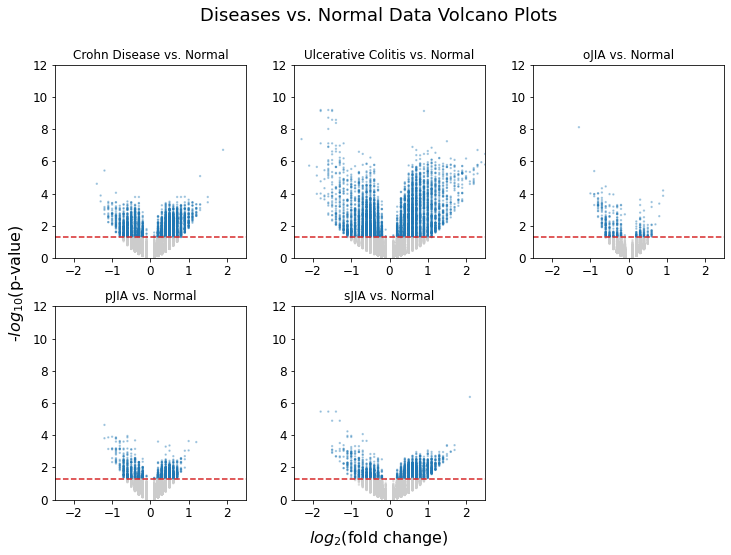

In [63]:
fig = plt.figure(figsize=(12,8))
fig.suptitle("Diseases vs. Normal Data Volcano Plots", fontsize=18)
fig.text(0.07, 0.5, r'-$log_{10}$(p-value)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.05, r'$log_2$(fold change)', ha='center', fontsize=16)

gs = GridSpec(2, 3, wspace=0.25, hspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])

axes = [ax1, ax2, ax3, ax4, ax5]

for i in range(5):
    col = np.where(-np.log10(de_df[diseases[i][0] + " vs 'normal'.pValue"])>-np.log10(0.05), 'C0', '0.8')
    axes[i].scatter(de_df[diseases[i][0] + " vs 'normal' .foldChange"],
                   -np.log10(de_df[diseases[i][0] + " vs 'normal'.pValue"]),
                   alpha=0.3, s=2, c=col)
    axes[i].set_title(diseases[i][2] + ' vs. Normal')
    axes[i].set_ylim([0,12])
    axes[i].set_xlim([-2.5,2.5])
    axes[i].tick_params(labelsize=12)
    axes[i].axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed')

As expected, all of the diseases display a good number of genes with significant fold change compared to samples without disease. We can also see that ulcerative colitis fold change overall shows the greatest degree of statistical significance.

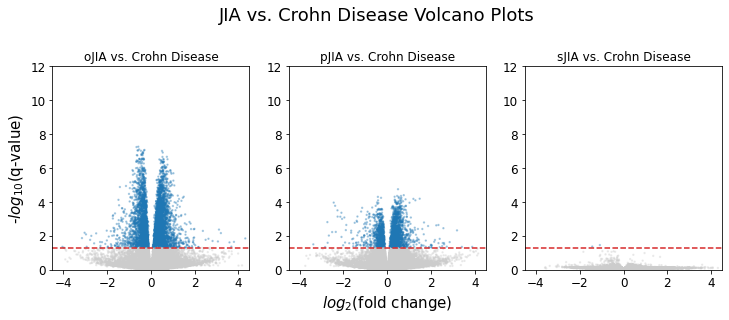

In [61]:
fig = plt.figure(figsize=(12,3.75))
fig.suptitle("JIA vs. Crohn Disease Volcano Plots", y=1.1, fontsize=18)

gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

axes = [ax1, ax2, ax3]
ax2.set_xlabel(r'$log_2$(fold change)', fontsize=15)
ax1.set_ylabel(r'-$log_{10}$(q-value)', fontsize=15)
for i in range(3):
    col = np.where(-np.log10(de_df_cd[diseases[i+2][0] + " vs 'Crohn disease'.pValue"])>-np.log10(0.05), 'C0', '0.8')
    axes[i].scatter(de_df_cd[diseases[i+2][0] + " vs 'Crohn disease' .foldChange"], 
                    -np.log10(de_df_cd[diseases[i+2][0] + " vs 'Crohn disease'.pValue"]), 
                    alpha=0.3, s=2, c=col)
    axes[i].set_title(diseases[i+2][2] + ' vs. Crohn Disease')
    axes[i].set_ylim([0,12])
    axes[i].set_xlim([-4.5,4.5])
    axes[i].tick_params(labelsize=12)
    axes[i].axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed')

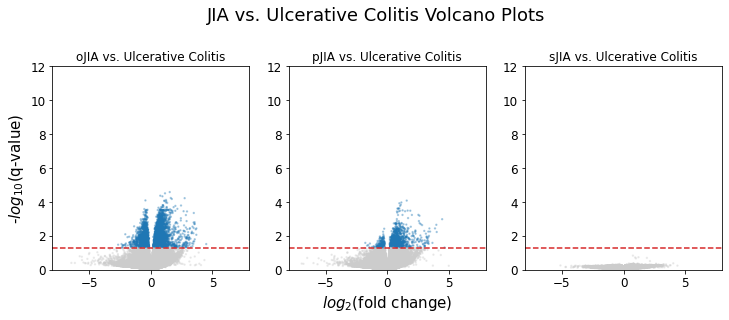

In [62]:
fig = plt.figure(figsize=(12,3.75))
fig.suptitle("JIA vs. Ulcerative Colitis Volcano Plots", y=1.1, fontsize=18)

gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

axes = [ax1, ax2, ax3]
ax2.set_xlabel(r'$log_2$(fold change)', fontsize=15)
ax1.set_ylabel(r'-$log_{10}$(q-value)', fontsize=15)
for i in range(3):
    col = np.where(-np.log10(de_df_uc[diseases[i+2][0] + " vs 'ulcerative colitis (disease)'.pValue"])>-np.log10(0.05), 'C0', '0.8')
    axes[i].scatter(de_df_uc[diseases[i+2][0] + " vs 'ulcerative colitis (disease)' .foldChange"], 
                    -np.log10(de_df_uc[diseases[i+2][0] + " vs 'ulcerative colitis (disease)'.pValue"]), 
                    alpha=0.3, s=2, c=col)
    axes[i].set_title(diseases[i+2][2] + ' vs. Ulcerative Colitis')
    axes[i].set_ylim([0,12])
    axes[i].set_xlim([-8,8])
    axes[i].tick_params(labelsize=12)
    axes[i].axhline(-np.log10(0.05), color=sns.color_palette()[3], linestyle='dashed')

As we saw in the sJIA vs. Crohn disease and sJIA vs. ulcerative colitis volcano plots, there were no genes that showed significant fold change between sJIA and IBD (Crohn disease and ulcerative colitis). On the other hand, oJIA and pJIA showed a good amount of observations that had significant fold changes against IBD. This confirms the expectation that sJIA is most similar to IBD compared to the other JIA subtypes.

## Data Wrangling: Filtering out signficantly upregulated genes

I filtered out significantly upregulated genes in each disease conditions from the three datasets. I also printed the dimensions of each sliced set. The sJIA vs. CD and sJIA vs. UC sliced sets also confirms the finding from the volcano plots that there were no significant differences in gene expression between sJIA and IBD.

In [9]:
# boolean series of upregulated genes and alpha = 0.05 genes
fc_truth_series = []
q_val_truth_series = []
fc_truth_series_cd = []
q_val_truth_series_cd = []
fc_truth_series_uc = []
q_val_truth_series_uc = []
for disease in diseases:
    fc_truth_series.append(de_df[disease[0] + " vs 'normal' .foldChange"] > 0)
    q_val_truth_series.append(de_df[disease[0] + " vs 'normal'.pValue"] < 0.05)
    
for i in range(2,5):
    fc_truth_series_cd.append(de_df_cd[diseases[i][0] + " vs 'Crohn disease' .foldChange"] > 0)
    q_val_truth_series_cd.append(de_df_cd[diseases[i][0] + " vs 'Crohn disease'.pValue"] < 0.05)
    fc_truth_series_uc.append(de_df_uc[diseases[i][0] + " vs 'ulcerative colitis (disease)' .foldChange"] > 0)
    q_val_truth_series_uc.append(de_df_uc[diseases[i][0] + " vs 'ulcerative colitis (disease)'.pValue"] < 0.05)

# filter genes that are significantly upregulated in diseases vs normal
de_df_slice = []
de_df_slice_cd = []
de_df_slice_uc = []
for i in range(5):
    de_df_slice.append(de_df[fc_truth_series[i] & q_val_truth_series[i]])
    
for i in range(3):
    de_df_slice_cd.append(de_df_cd[fc_truth_series_cd[i] & q_val_truth_series_cd[i]])
    de_df_slice_uc.append(de_df_uc[fc_truth_series_uc[i] & q_val_truth_series_uc[i]])

# print dimension of each sliced dataframe
print('\033[1m' + "DISEASE VS. NORMAL" + '\033[0m') 
for i in range(5):
    print(diseases[i][1] + ":" + str(de_df_slice[i].shape))
    
print('\033[1m' + "\nJIA VS. CROHN DISEASE" + '\033[0m')
for i in range(3):
    print(diseases[i+2][1] + ":" + str(de_df_slice_cd[i].shape))
    
print('\033[1m' + "\nJIA VS. ULCERATIVE COLITIS" + '\033[0m')
for i in range(3):
    print(diseases[i+2][1] + ":" + str(de_df_slice_uc[i].shape))

DISEASE VS. NORMAL
Crohn Disease:(2274, 12)
Ulcerative Colitis:(3345, 12)
Oligoarticular Juvenile Idiopathic Arthritis:(165, 12)
Polyarticular Juvenile Idiopathic Arthritis:(968, 12)
Systemic-onset Juvenile Idiopathic Arthritis:(1837, 12)

JIA VS. CROHN DISEASE
Oligoarticular Juvenile Idiopathic Arthritis:(3735, 7)
Polyarticular Juvenile Idiopathic Arthritis:(1500, 7)
Systemic-onset Juvenile Idiopathic Arthritis:(0, 7)

JIA VS. ULCERATIVE COLITIS
Oligoarticular Juvenile Idiopathic Arthritis:(3241, 7)
Polyarticular Juvenile Idiopathic Arthritis:(1167, 7)
Systemic-onset Juvenile Idiopathic Arthritis:(0, 7)


## Analysis: One-Tailed Hypergeometric (Fisher's) Test

### Disease vs. Normal

In [10]:
en_array = []
p_array = []
for pathway in pathways:
    en_row = [pathway[0]]
    p_row = [pathway[0]]
    for i in range(5):
        # number of genes that are in our input set AND our gene ontology of interest
        k = np.sum(de_df_slice[i]['Gene Name'].isin(pathway[1]))
        # number of genes in our input set in total
        N = len(de_df_slice[i])
        # number of genes in our in our reference set AND our gene ontology of interest
        n = np.sum(de_df['Gene Name'].isin(pathway[1]))
        # number of genes in our reference set in total 
        M=len(de_df)
        # enrichment ratio
        en = (k/N)/(n/M)
        # p-value
        p = scipy.stats.hypergeom.sf(k=k-1, N=N, n=n, M=M)
        en_row.append(en)
        p_row.append(p)
    en_array.append(en_row)
    p_array.append(p_row)
    
en_df = pd.DataFrame(en_array, columns = ['Pathway','Crohn Disease','Ulcerative Colitis', 'oJIA', 'pJIA', 'sJIA'])
en_df = en_df.set_index('Pathway')

p_df = pd.DataFrame(p_array, columns = ['Pathway','Crohn Disease','Ulcerative Colitis', 'oJIA', 'pJIA', 'sJIA'])
p_df = p_df.set_index('Pathway')

The following table contains the **enrichment ratio** for each signaling pathway and disease (higher enrichment ratio = greater degree of over-representation):

In [11]:
display(en_df)

,Crohn Disease,Ulcerative Colitis,oJIA,pJIA,sJIA
Pathway,,,,,
NOD-Like Receptor,2.865,2.226,0.000,2.472,3.474
Toll-Like Receptor,2.894,2.332,0.000,2.014,3.052
IL-17,2.626,2.210,0.000,2.937,3.251
T-Cell Receptor,2.413,1.956,1.279,2.180,2.528


The following table shows the resulting **p-values** from the one-tailed Fisher's test:

In [12]:
display(p_df)

,Crohn Disease,Ulcerative Colitis,oJIA,pJIA,sJIA
Pathway,,,,,
NOD-Like Receptor,3.628e-12,1.295e-09,1.000,3.646e-04,5.033e-15
Toll-Like Receptor,1.927e-07,1.313e-06,1.000,4.488e-02,8.354e-07
IL-17,2.317e-05,3.762e-05,1.000,1.994e-03,7.967e-07
T-Cell Receptor,1.404e-05,1.064e-04,0.545,1.633e-02,3.814e-05


The analysis showed some expected and unexpected results. It is known that the innate immune system is strongly involved in the pathogenesis of IBD (Crohn disease and ulcerative colitis). However, there were significant over-representations of both innate and adaptive immune system related pathways. The same goes for sJIA, which was found to be similar to IBD compared to the rest of the JIA subtypes. <br>

The analysis with oJIA dataset did not show any significant results, most likely due to the small sample size (165). As a result, I will be excluding oJIA data from GSEA in the next section. <br>

I expected an over-representation of adaptive immune system pathways (IL-17, T-cell receptor) in the pJIA data analysis and my expectations were met. On the other hand, there was also an innate immune system pathway that was unexpectedly  over-represented in pJIA (NOD-like receptor pathway). This was highly unexpected because NOD-receptors are known to play a pivotal role in innate immunity. The toll-like receptor pathway was also over-represented in pJIA, although it just passed the alpha = 0.05 cutoff with a p-value of 0.045.

### JIA vs. Crohn Disease

In [86]:
en_array = []
p_array = []
for pathway in pathways:
    en_row = [pathway[0]]
    p_row = [pathway[0]]
    for i in range(3):
        # number of genes that are in our input set AND our gene ontology of interest
        k = np.sum(de_df_slice_cd[i]['Gene Name'].isin(pathway[1]))
        # number of genes in our input set in total
        N = len(de_df_slice_cd[i])
        # number of genes in our in our reference set AND our gene ontology of interest
        n = np.sum(de_df_cd['Gene Name'].isin(pathway[1]))
        # number of genes in our reference set in total 
        M=len(de_df_cd)
        # enrichment ratio
        en = (k/N)/(n/M)
        # p-value
        p = scipy.stats.hypergeom.sf(k=k-1, N=N, n=n, M=M)
        en_row.append(en)
        p_row.append(p)
    en_array.append(en_row)
    p_array.append(p_row)
    
en_df = pd.DataFrame(en_array, columns = ['Pathway', 'oJIA', 'pJIA', 'sJIA'])
en_df = en_df.set_index('Pathway')

p_df = pd.DataFrame(p_array, columns = ['Pathway', 'oJIA', 'pJIA', 'sJIA'])
p_df = p_df.set_index('Pathway')

The following table contains the **enrichment ratio** for each signaling pathway and disease:

In [87]:
display(en_df)

,oJIA,pJIA,sJIA
Pathway,,,
NOD-Like Receptor,0.603,0.600,NaN
Toll-Like Receptor,0.516,0.367,NaN
IL-17,0.879,0.398,NaN
T-Cell Receptor,1.499,0.649,NaN


The following table shows the resulting **p-values** from the one-tailed Fisher's test:

In [88]:
display(p_df)

,oJIA,pJIA,sJIA
Pathway,,,
NOD-Like Receptor,0.992,0.939,1.0
Toll-Like Receptor,0.987,0.975,1.0
IL-17,0.724,0.965,1.0
T-Cell Receptor,0.028,0.871,1.0


As expected, our pathways did not show any over-representation in sJIA compared to Crohn disease because it is the most similar JIA type to IBD. It was also expected that many of the immune system pathways are not over-represented in JIA compared to Crohn disease since they are both conditions that affect the immune system. The only statistically significant result was an over-representation of the t-cell receptor pathway in oJIA compared to Crohn disease.

### JIA vs. Ulcerative Colitis

In [89]:
en_array = []
p_array = []
for pathway in pathways:
    en_row = [pathway[0]]
    p_row = [pathway[0]]
    for i in range(3):
        # number of genes that are in our input set AND our gene ontology of interest
        k = np.sum(de_df_slice_uc[i]['Gene Name'].isin(pathway[1]))
        # number of genes in our input set in total
        N = len(de_df_slice_uc[i])
        # number of genes in our in our reference set AND our gene ontology of interest
        n = np.sum(de_df_uc['Gene Name'].isin(pathway[1]))
        # number of genes in our reference set in total 
        M=len(de_df_uc)
        # enrichment ratio
        en = (k/N)/(n/M)
        # p-value
        p = scipy.stats.hypergeom.sf(k=k-1, N=N, n=n, M=M)
        en_row.append(en)
        p_row.append(p)
    en_array.append(en_row)
    p_array.append(p_row)
    
en_df = pd.DataFrame(en_array, columns = ['Pathway', 'oJIA', 'pJIA', 'sJIA'])
en_df = en_df.set_index('Pathway')

p_df = pd.DataFrame(p_array, columns = ['Pathway', 'oJIA', 'pJIA', 'sJIA'])
p_df = p_df.set_index('Pathway')

The following table contains the **enrichment ratio** for each signaling pathway and disease:

In [90]:
display(en_df)

,oJIA,pJIA,sJIA
Pathway,,,
NOD-Like Receptor,0.370,0.772,NaN
Toll-Like Receptor,0.340,0.472,NaN
IL-17,0.552,1.023,NaN
T-Cell Receptor,1.427,0.417,NaN


The following table shows the resulting **p-values** from the one-tailed Fisher's test:

In [91]:
display(p_df)

,oJIA,pJIA,sJIA
Pathway,,,
NOD-Like Receptor,1.000,0.795,1.0
Toll-Like Receptor,0.998,0.929,1.0
IL-17,0.968,0.554,1.0
T-Cell Receptor,0.069,0.956,1.0


Once again, there was no pathway over-representation in sJIA compared to ulcerative colitis. We see a very similar result compared to the JIA vs. Crohn disease analysis. However, there weren't any statistically significant over-representation, although t-cell receptor pathway in oJIA came close at p-value = 0.069.

# Gene Set Enrichment Analysis (GSEA)

GSEA is another method of testing whether a certain gene (or pathway of genes) is comparatively upregulated in a set condition. We can use the fold change data to calculate the enrichment score (ES) and use random gene permutation to determine the statistical significance of the ES. Using the gene permutation, we can also calculate the normalized enrichment score (NES) for each gene, which allows us to compare enrichment levels between different genes.

The primary difference between GSEA and ORA is that ORA is focused on the overlap of genes in different datasets whereas GSEA looks at the gene expression change distribution to determine over-representation. Therefore, an advantage that GSEA has over ORA is that it can detect pathway upregulation even if the associated genes are not over-represented as long as the entire pathway is over-represented to some degree.

## Inflammatory Bowel Diseases (Crohn Disease and Ulcerative Colitis)

For this analysis, I decided to combine Crohn disease and ulcerative disease data into one IBD data. I filtered out genes that had fold change p-value < 0.05 for both diseases and averaged the fold change values.

In [92]:
# combining crohn disease and ulcerative disease data by filtering out genes that had p-value < 0.05 for both diseases
# averaged the fold change values
cd = de_df["'Crohn disease' vs 'normal'.pValue"] < 0.05
uc = de_df["'ulcerative colitis (disease)' vs 'normal'.pValue"] < 0.05
de_df_slice = de_df[cd & uc].set_index('Gene Name')
de_df_slice["IBD foldChange"] = de_df_slice["'Crohn disease' vs 'normal' .foldChange"] + de_df_slice["'ulcerative colitis (disease)' vs 'normal' .foldChange"]
de_df_slice["IBD foldChange"] = de_df_slice["IBD foldChange"].div(2)
de_df_sorted = de_df_slice.sort_values("IBD foldChange", ascending=False)

barcodes = []
for pathway in pathways:
    barcodes.append(de_df_sorted.index.isin(pathway[1]))

The following figure shows the running enrichment score, fold change, and pathway gene barcode for each signaling pathway:

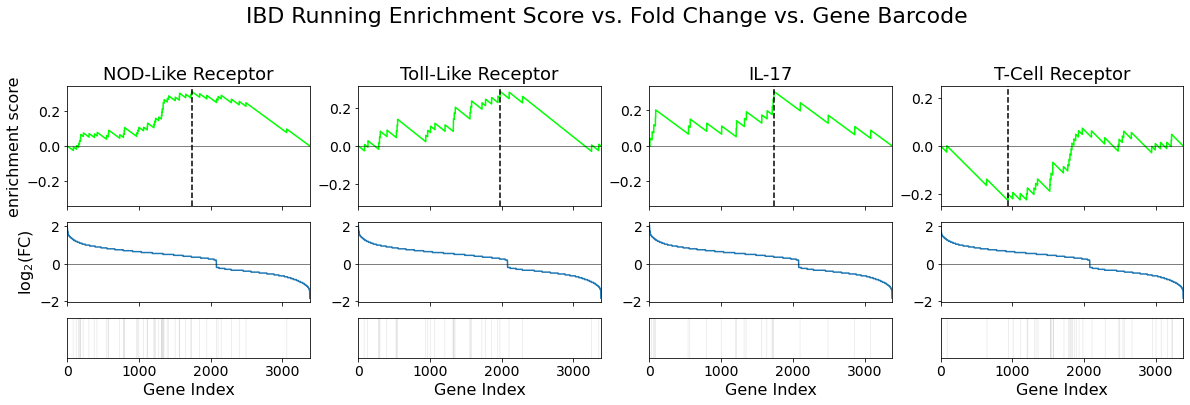

In [515]:
## Running enrichment score
np.random.seed(1701)

running_sum_storages = []
for i in range(4):
    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcodes[i])
    n_not_in_pathway = len(barcodes[i]) - np.sum(barcodes[i])
    for ele in barcodes[i]:
        if ele:
            running_sum += 1/n_in_pathway
        else:
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storages.append(running_sum_storage)
running_sum_storages = np.array(running_sum_storages)

# Visualization
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(20,5), gridspec_kw={'height_ratios': [3,2, 1]})
fig.suptitle("IBD Running Enrichment Score vs. Fold Change vs. Gene Barcode", y = 1.1, fontsize=22)

for i in range(4):
    axes[0][i].plot(running_sum_storages[i], color='lime')
    axes[0][i].axvline(np.argmax(np.abs(running_sum_storages[i])), color='k', linestyle='dashed')
    axes[0][i].axhline(0.0, color='k', linewidth=0.5)
    axes[0][i].set_ylim([-np.max(np.abs(running_sum_storages[i]))*1.1, np.max(np.abs(running_sum_storages[i]))*1.1])
    axes[1][i].plot(np.arange(3383)+0.5, de_df_sorted["IBD foldChange"].values)
    axes[1][i].axhline(0, color='k', linewidth=0.5)
    axes[2][i].imshow(de_df_sorted.index.isin(pathways[i][1]).reshape(-1,1).T, aspect='auto', cmap='binary')
    axes[2][i].set_yticks([])
    axes[2][i].set_xlabel('Gene Index', fontsize=16)
    axes[2][i].set_xlim([0,3383])

axes[0][0].set_title(pathways[0][0], fontsize=18)
axes[0][1].set_title(pathways[1][0], fontsize=18)
axes[0][2].set_title(pathways[2][0], fontsize=18)
axes[0][3].set_title(pathways[3][0], fontsize=18)
axes[0][0].set_ylabel('enrichment score', fontsize=16)
axes[1][0].set_ylabel(r'log$_2$(FC)', fontsize=16)
for ax in axes:
    for a in ax:
        a.tick_params(labelsize=14)

The barcode on the bottom row of the plot grid highlights the genes in each corresponding pathway. The black lines represent the index of genes associated with the signaling pathway. The middle row plots the fold change against the gene index. Positive fold change indicates upregulation and by comparing the middle and bottom plots, we can see that most of the pathways in the NOD-like receptor, toll-like receptor, and IL-17 pathways are upregulated. On the other hand, it appears that there are more genes in the t-cell receptors that were downregulated compared to the other pathways.

The top row of plots shows the running enrichment score vs. gene index for each pathway. It allows us to identify the Enrichment Score (ES) of the pathway, which is the point at which our running enrichment score reaches its highest deviation from zero. A positive ES indicates that the pathway is upregulated, although we cannot determine the statistical significance yet. We can see that the first three pathways' ES are positive whereas T-cell receptor pathway has a negative ES.

#### IBD Overall Enrichment Score (ES) for Each Pathway

In [493]:
# Enrichment Score (point at which our running enrichment score reaches its highest deviation from zero)
# positive ES = pathway is upregulated (but no statistical significance yet)
es_trues = []
for running_sum_storage in running_sum_storages:
    es_trues.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_df = pd.DataFrame(es_trues, ["NOD-like Receptor", "Toll-like Receptor", "IL-17", "T-cell Receptor"], 
                     columns = ["Enrichment Score"])
es_df

,Enrichment Score
NOD-like Receptor,0.311
Toll-like Receptor,0.285
IL-17,0.307
T-cell Receptor,-0.228


To determine the statistical significance of the ES, I performed a random gene permutation in which I scrambled the set of genes in our pathways and calculated the ES for each of the 10,000 permutations. Then I plotted the null ES distribution. The red line indicates the true ES determined above.

In [495]:
# gene permutation
es_null_storage_arrays = []
for i in range(4):
    n_permutations = 10_000
    es_null_storage_array = []
    for permute_n in range(n_permutations):
        barcode = de_df_sorted.index.isin(pathways[i][1])
        new_barcode = np.random.permutation(barcode)
        
        running_sum_storage = []
        running_sum = 0
        running_sum_storage.append(running_sum)
        n_in_pathway = np.sum(barcode)
        n_not_in_pathway = len(barcode) - np.sum(barcode)
        for ele in new_barcode:
            if ele: # gene is in gene set
                running_sum += 1/n_in_pathway
            else: # gene is not in gene set
                running_sum -= 1/n_not_in_pathway
            running_sum_storage.append(running_sum)
        running_sum_storage = np.array(running_sum_storage)
        # get value of max deviation from zero
        es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])
    es_null_storage_arrays.append(es_null_storage_array)
es_null_storage_arrays = np.array(es_null_storage_arrays)

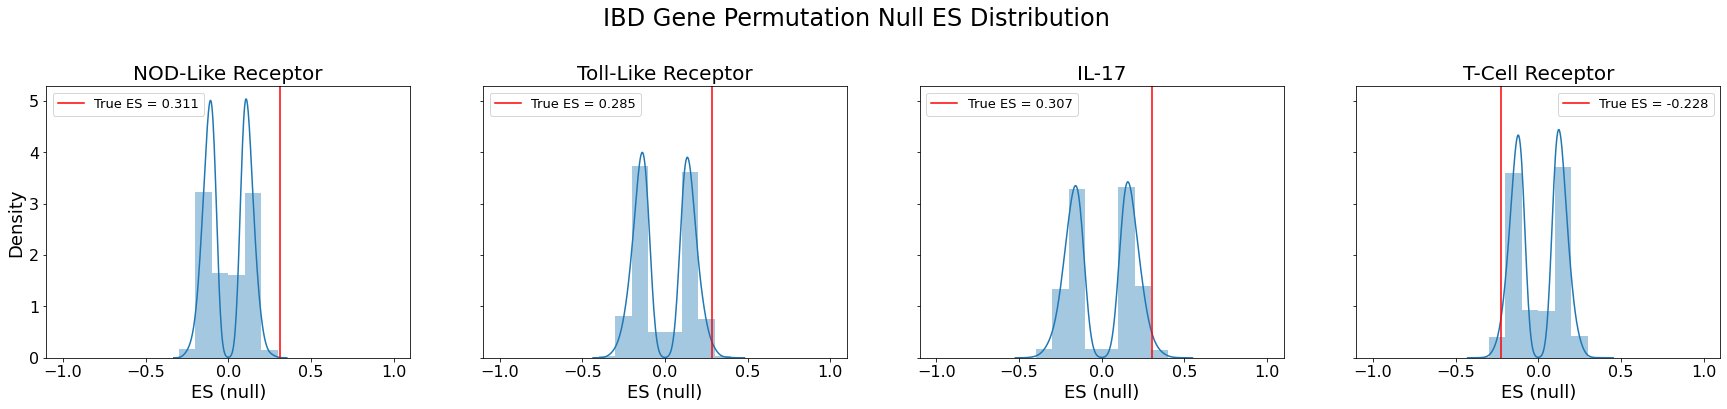

In [516]:
# visualization
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(30,5))
fig.suptitle("IBD Gene Permutation Null ES Distribution", y = 1.1, fontsize=24)

for i, ax in zip(range(4), axes.flat):
    sns.distplot(es_null_storage_arrays[i], bins=np.arange(-1,1.01,0.1), ax=ax)
    ax.axvline(es_trues[i], color='r', label='True ES = ' + str(round(es_trues[i], 3)))
    ax.legend(fontsize=13)
    ax.tick_params(labelsize=16)
    ax.set_title(pathways[i][0], fontsize=20)
    ax.set_xlabel('ES (null)', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)

#### IBD Empirical P-Value and Normalized Enrichment Score (NES) for Each Pathway

In [517]:
array = []
for i in range(4):
    pos_es = es_null_storage_arrays[i][es_null_storage_arrays[i] > 0] # get array of positive enrichment scores
    array.append([pathways[i][0], np.sum(pos_es >= es_trues[i])/len(pos_es), es_trues[i]/np.mean(np.abs(pos_es))])
    # Normalized Enrichment Score (used to compare which gene sets are "more enriched" than the others)

pd.options.display.float_format = '{:.3f}'.format
es_df = pd.DataFrame(array, columns = ['Pathway','Empirical p-value', "Normalized Enrichment Score"])
es_df = es_df.set_index('Pathway')
es_df

,Empirical p-value,Normalized Enrichment Score
Pathway,,
NOD-Like Receptor,0.000,2.586
Toll-Like Receptor,0.014,1.860
IL-17,0.029,1.712
T-Cell Receptor,1.000,-1.649


The resulting empirical p-values indicate that NOD-like receptor, toll-like receptor, and IL-17 pathways were indeed upregulated to a statistically significant degree in IBD patients compared to those without the disease. 

This result was both expected and unexpected. Since the innate immune system is known to be over-expressed in IBD patients, it was expected that NOD-like receptor and toll-like receptor pathways would be upregulated. However, IL-17 pathway, involved in the adaptive immune system, also showed significant upregulation.

## Polyarticular Juvenile Idiopathic Arthritis (pJIA)

In [518]:
de_df_slice = de_df[de_df["'polyarticular juvenile idiopathic arthritis' vs 'normal'.pValue"] < 0.05].set_index('Gene Name')
de_df_sorted = de_df_slice.sort_values("'polyarticular juvenile idiopathic arthritis' vs 'normal' .foldChange", ascending=False)

barcodes = []
for pathway in pathways:
    barcodes.append(de_df_sorted.index.isin(pathway[1]))

The following figure shows the running enrichment score, fold change, and pathway gene barcode for each signaling pathway:

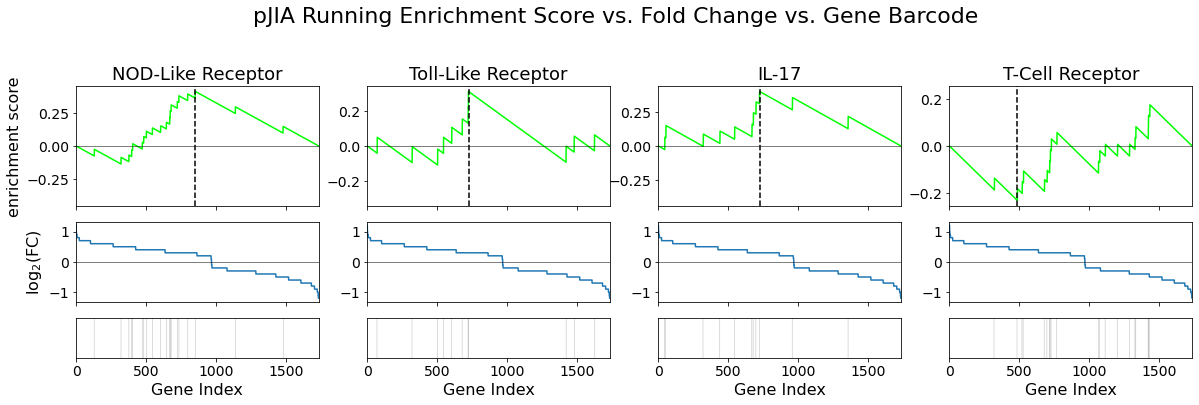

In [519]:
## Running enrichment score
np.random.seed(1701)

running_sum_storages = []
for i in range(4):
    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcodes[i])
    n_not_in_pathway = len(barcodes[i]) - np.sum(barcodes[i])
    for ele in barcodes[i]:
        if ele:
            running_sum += 1/n_in_pathway
        else:
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storages.append(running_sum_storage)
running_sum_storages = np.array(running_sum_storages)

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(20,5), gridspec_kw={'height_ratios': [3,2, 1]})
fig.suptitle("pJIA Running Enrichment Score vs. Fold Change vs. Gene Barcode", y = 1.1, fontsize=22)
 
# Visualization
for i in range(4):
    axes[0][i].plot(running_sum_storages[i], color='lime')
    axes[0][i].axvline(np.argmax(np.abs(running_sum_storages[i])), color='k', linestyle='dashed')
    axes[0][i].axhline(0.0, color='k', linewidth=0.5)
    axes[0][i].set_ylim([-np.max(np.abs(running_sum_storages[i]))*1.1, np.max(np.abs(running_sum_storages[i]))*1.1])
    axes[1][i].plot(np.arange(1734)+0.5, de_df_sorted["'polyarticular juvenile idiopathic arthritis' vs 'normal' .foldChange"].values)
    axes[1][i].axhline(0, color='k', linewidth=0.5)
    axes[2][i].imshow(de_df_sorted.index.isin(pathways[i][1]).reshape(-1,1).T, aspect='auto', cmap='binary')
    axes[2][i].set_yticks([])
    axes[2][i].set_xlabel('Gene Index', fontsize=16)
    axes[2][i].set_xlim([0,1734])
    

axes[0][0].set_title(pathways[0][0], fontsize=18)
axes[0][1].set_title(pathways[1][0], fontsize=18)
axes[0][2].set_title(pathways[2][0], fontsize=18)
axes[0][3].set_title(pathways[3][0], fontsize=18)
axes[0][0].set_ylabel('enrichment score', fontsize=16)
axes[1][0].set_ylabel(r'log$_2$(FC)', fontsize=16)
for ax in axes:
    for a in ax:
        a.tick_params(labelsize=14)

Similar to the result from IBD's analysis, we can see many of the genes in the first three pathways are upregulated where as there seems to be comparatively less upregulated genes in the T-cell receptor pathway. The ES also indicates that the first three pathways are upregulated and the T-cell receptor pathway is downregulated.

#### pJIA Overall Enrichment Score (ES) for Each Pathway

In [520]:
# Enrichment Score (point at which our running enrichment score reaches its highest deviation from zero)
# positive ES = pathway is upregulated (but no statistical significance yet)
es_trues = []
for running_sum_storage in running_sum_storages:
    es_trues.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_df = pd.DataFrame(es_trues, ["NOD-like Receptor", "Toll-like Receptor", "IL-17", "T-cell Receptor"], 
                     columns = ["Enrichment Score"])
es_df

,Enrichment Score
NOD-like Receptor,0.413
Toll-like Receptor,0.312
IL-17,0.403
T-cell Receptor,-0.232


The following figure shows the null ES distribution from the random gene permutation along with the true ES plotted as a red line for each signaling pathway:

In [521]:
# gene permutation
es_null_storage_arrays = []
for i in range(4):
    n_permutations = 10_000
    es_null_storage_array = []
    for permute_n in range(n_permutations):
        barcode = de_df_sorted.index.isin(pathways[i][1])
        new_barcode = np.random.permutation(barcode)
        
        running_sum_storage = []
        running_sum = 0
        running_sum_storage.append(running_sum)
        n_in_pathway = np.sum(barcode)
        n_not_in_pathway = len(barcode) - np.sum(barcode)
        for ele in new_barcode:
            if ele: # gene is in gene set
                running_sum += 1/n_in_pathway
            else: # gene is not in gene set
                running_sum -= 1/n_not_in_pathway
            running_sum_storage.append(running_sum)
        running_sum_storage = np.array(running_sum_storage)
        # get value of max deviation from zero
        es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])
    es_null_storage_arrays.append(es_null_storage_array)
es_null_storage_arrays = np.array(es_null_storage_arrays)

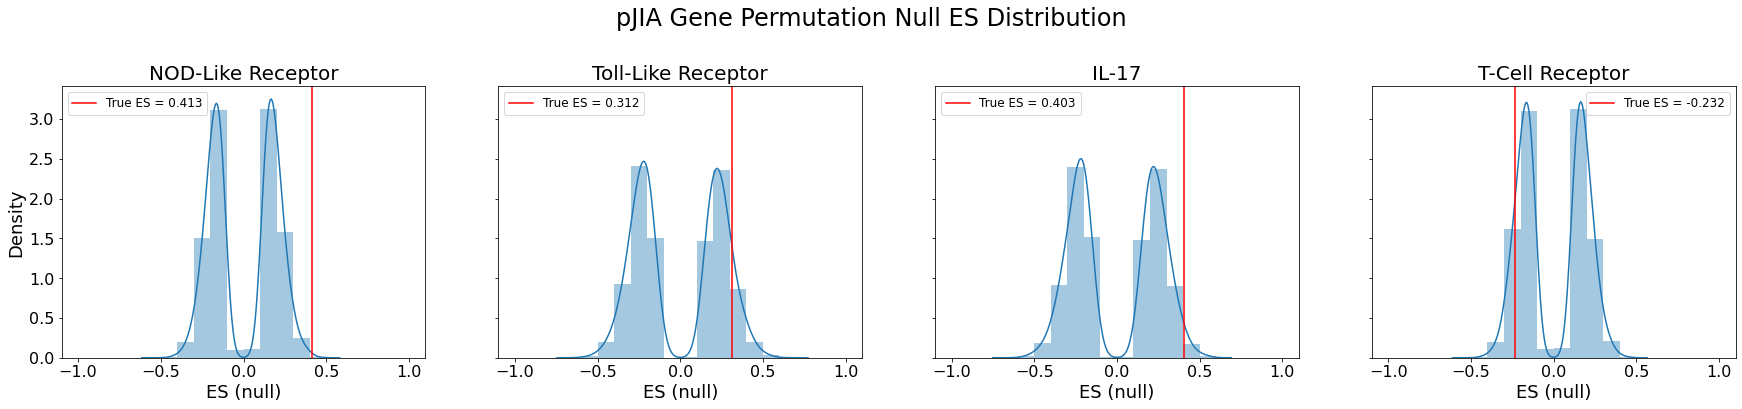

In [524]:
# visualization
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(30,5))
fig.suptitle("pJIA Gene Permutation Null ES Distribution", y = 1.1, fontsize=24)

for i, ax in zip(range(4), axes.flat):
    sns.distplot(es_null_storage_arrays[i], bins=np.arange(-1,1.01,0.1), ax=ax)
    ax.axvline(es_trues[i], color='r', label='True ES = ' + str(round(es_trues[i], 3)))
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=16)
    ax.set_title(pathways[i][0], fontsize=20)
    ax.set_xlabel('ES (null)', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)

#### pJIA Empirical P-Value and Normalized Enrichment Score (NES) for Each Pathway

In [526]:
array = []
for i in range(4):
    pos_es = es_null_storage_arrays[i][es_null_storage_arrays[i] > 0] # get array of positive enrichment scores
    array.append([pathways[i][0], np.sum(pos_es >= es_trues[i])/len(pos_es), es_trues[i]/np.mean(np.abs(pos_es))])
    # Normalized Enrichment Score (used to compare which gene sets are "more enriched" than the others)

es_df = pd.DataFrame(array, columns = ['Pathway','Empirical p-value', "Normalized Enrichment Score"])
es_df = es_df.set_index('Pathway')
es_df

,Empirical p-value,Normalized Enrichment Score
Pathway,,
NOD-Like Receptor,0.001,2.190
Toll-Like Receptor,0.191,1.254
IL-17,0.037,1.629
T-Cell Receptor,1.000,-1.251


The resulting empirical p-values indicate that NOD-like receptor and IL-17 pathways were indeed upregulated to a statistically significant degree in pJIA patients compared to those without the disease. However, although IL-17 pathway's ES was positive (indicating upregulation), it was not found to be statistically significant.

The GSEA on the pJIA vs. normal dataset showed some very unexpected results. First, similar to ORA, I saw an overexpression of the NOD-like receptor pathway, which goes against the expectation that pJIA involves adaptive immunity. Also, although T-cell receptor pathway is involved in the adaptive immune system, there wasn't an overexpression of the pathway. In fact, there seems to be an underexpression of the pathway, which also goes against the findings from ORA.

## Systemic-onset Juvenile Idiopathic Arthritis (sJIA)

In [527]:
de_df_slice = de_df[de_df["'systemic-onset juvenile idiopathic arthritis' vs 'normal'.pValue"] < 0.05].set_index('Gene Name')
de_df_sorted = de_df_slice.sort_values("'systemic-onset juvenile idiopathic arthritis' vs 'normal' .foldChange", ascending=False)

barcodes = []
for pathway in pathways:
    barcodes.append(de_df_sorted.index.isin(pathway[1]))

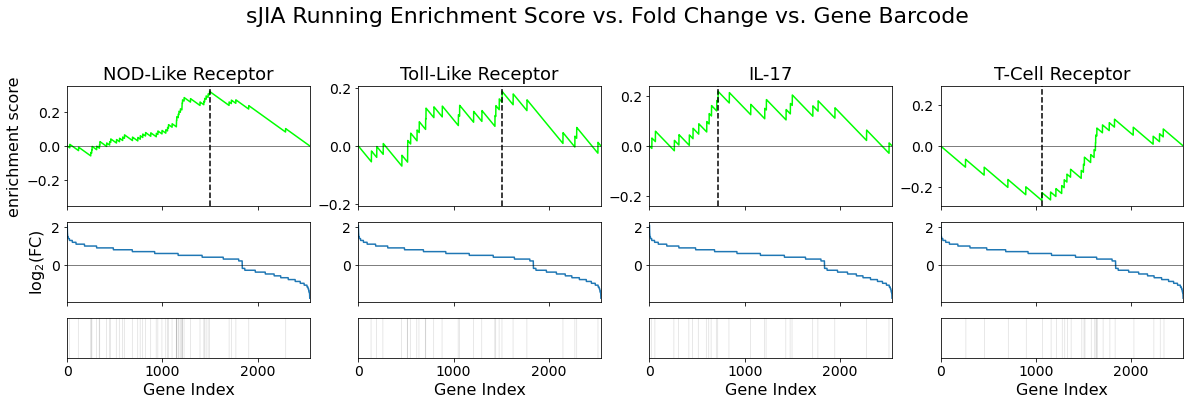

In [528]:
## Running enrichment score
np.random.seed(1701)

running_sum_storages = []
for i in range(4):
    running_sum_storage = []
    running_sum = 0
    running_sum_storage.append(running_sum)
    n_in_pathway = np.sum(barcodes[i])
    n_not_in_pathway = len(barcodes[i]) - np.sum(barcodes[i])
    for ele in barcodes[i]:
        if ele:
            running_sum += 1/n_in_pathway
        else:
            running_sum -= 1/n_not_in_pathway
        running_sum_storage.append(running_sum)
    running_sum_storages.append(running_sum_storage)
running_sum_storages = np.array(running_sum_storages)

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(20,5), gridspec_kw={'height_ratios': [3,2, 1]})
fig.suptitle("sJIA Running Enrichment Score vs. Fold Change vs. Gene Barcode", y = 1.1, fontsize=22)

# Visualization
for i in range(4):
    axes[0][i].plot(running_sum_storages[i], color='lime')
    axes[0][i].axvline(np.argmax(np.abs(running_sum_storages[i])), color='k', linestyle='dashed')
    axes[0][i].axhline(0.0, color='k', linewidth=0.5)
    axes[0][i].set_ylim([-np.max(np.abs(running_sum_storages[i]))*1.1, np.max(np.abs(running_sum_storages[i]))*1.1])
    axes[1][i].plot(np.arange(2547)+0.5, de_df_sorted["'systemic-onset juvenile idiopathic arthritis' vs 'normal' .foldChange"].values)
    axes[1][i].axhline(0, color='k', linewidth=0.5)
    axes[2][i].imshow(de_df_sorted.index.isin(pathways[i][1]).reshape(-1,1).T, aspect='auto', cmap='binary')
    axes[2][i].set_yticks([])
    axes[2][i].set_xlabel('Gene Index', fontsize=16)
    axes[2][i].set_xlim([0,2547])
    

axes[0][0].set_title(pathways[0][0], fontsize=18)
axes[0][1].set_title(pathways[1][0], fontsize=18)
axes[0][2].set_title(pathways[2][0], fontsize=18)
axes[0][3].set_title(pathways[3][0], fontsize=18)
axes[0][0].set_ylabel('enrichment score', fontsize=16)
axes[1][0].set_ylabel(r'log$_2$(FC)', fontsize=16)
for ax in axes:
    for a in ax:
        a.tick_params(labelsize=14)

We again see very similar results from IBD and pJIA.

#### sJIA Overall Enrichment Score (ES) for Each Pathway

In [529]:
# Enrichment Score (point at which our running enrichment score reaches its highest deviation from zero)
# positive ES = pathway is upregulated (but no statistical significance yet)
es_trues = []
for running_sum_storage in running_sum_storages:
    es_trues.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])

es_df = pd.DataFrame(es_trues, ["NOD-like Receptor", "Toll-like Receptor", "IL-17", "T-cell Receptor"], 
                     columns = ["Enrichment Score"])
es_df

,Enrichment Score
NOD-like Receptor,0.319
Toll-like Receptor,0.187
IL-17,0.219
T-cell Receptor,-0.266


The following figure shows the null ES distribution from the random gene permutation along with the true ES plotted as a red line for each signaling pathway:

In [530]:
# gene permutation
es_null_storage_arrays = []
for i in range(4):
    n_permutations = 10_000
    es_null_storage_array = []
    for permute_n in range(n_permutations):
        barcode = de_df_sorted.index.isin(pathways[i][1])
        new_barcode = np.random.permutation(barcode)
        
        running_sum_storage = []
        running_sum = 0
        running_sum_storage.append(running_sum)
        n_in_pathway = np.sum(barcode)
        n_not_in_pathway = len(barcode) - np.sum(barcode)
        for ele in new_barcode:
            if ele: # gene is in gene set
                running_sum += 1/n_in_pathway
            else: # gene is not in gene set
                running_sum -= 1/n_not_in_pathway
            running_sum_storage.append(running_sum)
        running_sum_storage = np.array(running_sum_storage)
        # get value of max deviation from zero
        es_null_storage_array.append(running_sum_storage[np.argmax(np.abs(running_sum_storage))])
    es_null_storage_arrays.append(es_null_storage_array)
es_null_storage_arrays = np.array(es_null_storage_arrays)

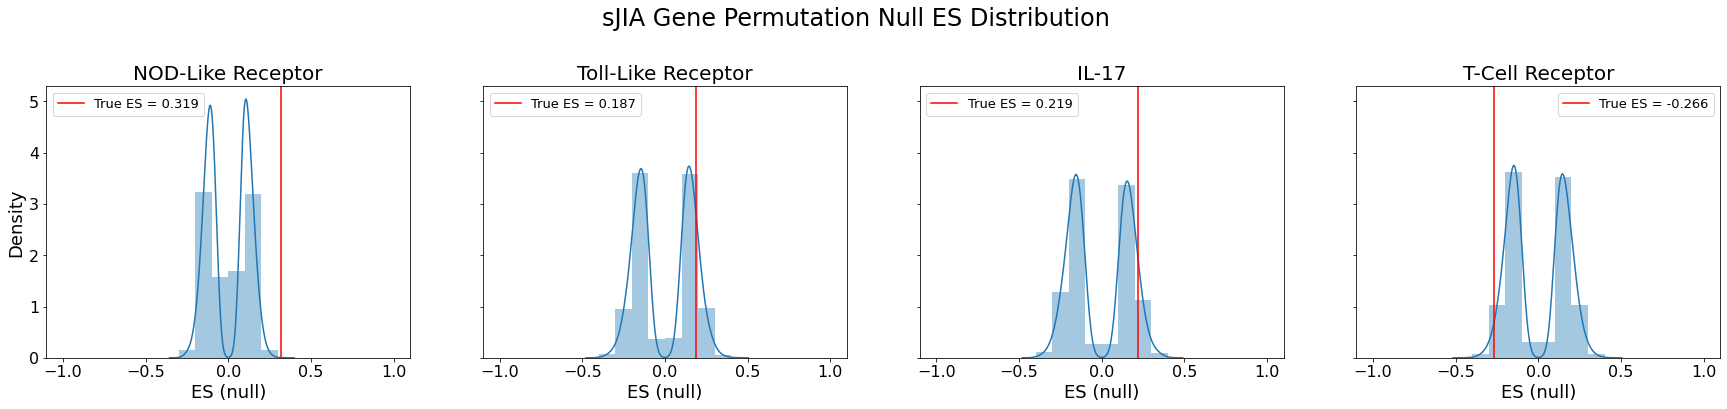

In [531]:
# visualization
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(30,5))
fig.suptitle("sJIA Gene Permutation Null ES Distribution", y = 1.1, fontsize=24)

for i, ax in zip(range(4), axes.flat):
    sns.distplot(es_null_storage_arrays[i], bins=np.arange(-1,1.01,0.1), ax=ax)
    ax.axvline(es_trues[i], color='r', label='True ES = ' + str(round(es_trues[i], 3)))
    ax.legend(fontsize=13)
    ax.tick_params(labelsize=16)
    ax.set_title(pathways[i][0], fontsize=20)
    ax.set_xlabel('ES (null)', fontsize=18)
    ax.set_ylabel('Density', fontsize=18)

#### sJIA Empirical P-Value and Normalized Enrichment Score (NES) for Each Pathway

In [532]:
array = []
for i in range(4):
    pos_es = es_null_storage_arrays[i][es_null_storage_arrays[i] > 0] # get array of positive enrichment scores
    array.append([pathways[i][0], np.sum(pos_es >= es_trues[i])/len(pos_es), es_trues[i]/np.mean(np.abs(pos_es))])
    # Normalized Enrichment Score (used to compare which gene sets are "more enriched" than the others)

es_df = pd.DataFrame(array, columns = ['Pathway','Empirical p-value', "Normalized Enrichment Score"])
es_df = es_df.set_index('Pathway')
es_df

,Empirical p-value,Normalized Enrichment Score
Pathway,,
NOD-Like Receptor,0.000,2.650
Toll-Like Receptor,0.270,1.153
IL-17,0.171,1.285
T-Cell Receptor,1.000,-1.616


The resulting empirical p-values indicate that NOD-like receptor pathway was upregulated to a statistically significant degree in sJIA patients compared to those without the disease. 

As expected, the GSEA on sJIA vs. normal data showed a lack of statistically significant over-expression of the adaptive immune system pathways. However, although NOD-like receptor was upregulated, the other innate immune system pathway, toll-like receptor pathway, was not significantly upregulated.

# Conclusion

Mo et al. paper concluded that the innate immune system is strongly involved in the pathogenesis of IBD and the adaptive immune system is strongly involved in JIA. They also concluded that sJIA is the most similar to IBD compared to the other types of JIA. Therefore, I expected to see an upregulation of the NOD-like receptor and toll-like receptor pathways in Crohn disease, ulcerative colitis, and SJIA. I also expected to see an upregulation of the IL-17 and T-cell receptor pathways in oJIA and pJIA. Since oJIA's sample size was too small, we were not able to make any conclusions in either analyses.

There was a mix of expected and unexpected results. ORA indicated that all four signaling pathways are upregulated in IBD, sJIA, and pJIA. On the other hand, GSEA found that T-cell receptor pathway is not upregulated in any of the diseases whereas NOD-like receptor pathway is upregulated in all of the diseases.